## Predict traffic flow in Porto

### Summary

#### We have created a supervised machine learning model for predicting car traffic per minute in a specific period of the day in Porto streets using traffic flow, air quality, noise levels and the weather observed in the previous period of the day. 

#### Periods of the day were divided into 8 periods: late night and early morning period, morning rush hours, morning period, lunch period, afternoon period, evening rush hours,  dinner time and night. The model developed is independent of the year, requiring as input the month, day of the month, day of the week, period of the day to be predicted and the traffic for the same road segment and enviromental variables both observed in the day period immediately before. 

#### Several models were considered but ensembled boosting and bagging based models showed to present best forecasts. LightGBM and Random Forest (RF) produced nearly the sames results with RF showing a slight better prediction while LightGBM a slighlty faster implementation. Our predictions present an averaged error lower than 20 % (mean average percentage error - mape) in predicting the traffic flow for the current period for each of the locations of the loop sensors in the test set. Major variables showed to be traffic flow in the previous period for a determined location, the period of the day to have the traffic predicted, besides solar radiation and noise levels in Porto city in the previous period.

#### Due to lack of time, only 2018 and 2019 data were considered, mape could be decreased further by using other years information.

# 1- EDA

### Analysis of traffic using big data tools

In [1]:
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster("local[*]").setAppName("traffic_Porto").set('spark.disk.memory', '1g')
sc = SparkContext(conf = conf)
import databricks.koalas as ks
ks.set_option('compute.default_index_type','distributed')

In [2]:
traffic_2018=ks.read_csv('traffic_flow_2018.csv')

In [4]:
#maps hours into periods of day
period=[]
for time in traffic_2018.iterrows():
    if time[1][10] >= '00:00:01' and time[1][10] <= '07:12:00':  #late night and early morning period
        period.append((time[1][10],0))
    elif time[1][10] >= '07:12:01' and time[1][10] <= '09:36:00': #rush morning hours
        period.append((time[1][10],1))        
    elif time[1][10] >= '09:36:01' and time[1][10] <= '12:00:00': #morning
        period.append((time[1][10],2))
    elif time[1][10] >= '12:00:01' and time[1][10] <= '14:24:00': #lunch time
        period.append((time[1][10],3))
    elif time[1][10] >= '14:24:01' and time[1][10] <= '16:48:00': #afternoon
        period.append((time[1][10],4))
    elif time[1][10] >= '16:48:01' and time[1][10] <= '19:12:00': #evening rush hours
        period.append((time[1][10],5))
    elif time[1][10] >= '19:12:01' and time[1][10] <= '21:36:00': #dinner time
        period.append((time[1][10],6))
    else:
        period.append((time[1][10],7))                            # night

In [218]:
#period to Koalas DataFrame
Period=ks.DataFrame(period, columns=['indice', 'code_period'])
Period_woutDuplicates= Period.drop_duplicates()

In [13]:
traffic_2018=traffic_2018.merge(Period_woutDuplicates, left_on='time_from', right_on='indice')

In [15]:
#drop columns not considered relevant
traffic_2018_short=traffic_2018.drop(['entity_id', 'entity_type', 'dataprovider', 'source', 'indice',  'laneid','lanedirection', 'dateobservedfrom' ])

In [37]:
#grooup by date, location and period of day and average traffic intensity
traffic_ = traffic_2018_short.groupby(['name', 'date_from', 'code_period']).agg({'intensity': ['mean']})
traffic_.columns = ['AveragedtrafficPerPeriod']
traffic_ = traffic_.reset_index()

In [39]:
#averaged car flow per min per day period per location in a specific day
time_interval = 5 # min and is constant
traffic_['AveragedtrafficPerPeriod']=traffic_['AveragedtrafficPerPeriod'] / time_interval

In [44]:
traffic_.to_csv('traffic_2018_coded.csv') # to be used later

In [2]:
#the same for 2019
traffic_2019=ks.read_csv('traffic_flow_2019.csv')

In [4]:
#maps hours into periods of day
period2=[]
for time in traffic_2019.iterrows():
    if time[1][10] >= '00:00:01' and time[1][10] <= '07:12:00':
        period2.append((time[1][10],0))
    elif time[1][10] >= '07:12:01' and time[1][10] <= '09:36:00':
        period2.append((time[1][10],1))        
    elif time[1][10] >= '09:36:01' and time[1][10] <= '12:00:00':
        period2.append((time[1][10],2))
    elif time[1][10] >= '12:00:01' and time[1][10] <= '14:24:00':
        period2.append((time[1][10],3))
    elif time[1][10] >= '14:24:01' and time[1][10] <= '16:48:00':
        period2.append((time[1][10],4))
    elif time[1][10] >= '16:48:01' and time[1][10] <= '19:12:00':
        period2.append((time[1][10],5))
    elif time[1][10] >= '19:12:01' and time[1][10] <= '21:36:00':
        period2.append((time[1][10],6))
    else:
        period2.append((time[1][10],7))

In [5]:
Period2=ks.DataFrame(period2, columns=['indice', 'code_period'])
Period2_woutDuplicates= Period2.drop_duplicates()

In [6]:
traffic_2019=traffic_2019.merge(Period2_woutDuplicates, left_on='time_from', right_on='indice')

In [7]:
traffic_2019_short=traffic_2019.drop(['entity_id', 'entity_type', 'dataprovider', 'source', 'indice',  'laneid','lanedirection', 'dateobservedfrom' ])

In [8]:
traffic2_ = traffic_2019_short.groupby(['name', 'date_from', 'code_period']).agg({'intensity': ['mean']})
traffic2_.columns = ['AveragedtrafficPerPeriod']
traffic2_ = traffic2_.reset_index()

In [9]:
traffic2_['AveragedtrafficPerPeriod']=traffic2_['AveragedtrafficPerPeriod']/5 #average car flow per min

In [10]:
traffic2_.to_csv('traffic_2019_coded',  num_files=1) # to be used later

In [2]:
sc.stop

## After dataset reduction with pySpark further data analysis is held with pandas 

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import holidays
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
import lightgbm as lgb

### Analysis from year 2018

#### Reading quality of air in 2018

In [3]:
quality_2018=pd.read_csv('air_quality_2018.csv', encoding='unicode_escape')

In [4]:
#maps hours into the same periods of day
air=[]
for time in quality_2018.iterrows():
    if time[1][13] >= '00:00:01' and time[1][13] <= '07:12:00':
        air.append(0)
    elif time[1][13] >= '07:12:01' and time[1][13] <= '09:36:00':
        air.append(1)        
    elif time[1][13] >= '09:36:01' and time[1][13] <= '12:00:00':
        air.append(2)
    elif time[1][13] >= '12:00:01' and time[1][13] <= '14:24:00':
        air.append(3)
    elif time[1][13] >= '14:24:01' and time[1][13] <= '16:48:00':
        air.append(4)
    elif time[1][13] >= '16:48:01' and time[1][13] <= '19:12:00':
        air.append(5)
    elif time[1][13] >= '19:12:01' and time[1][13] <= '21:36:00':
        air.append(6)
    else:
        air.append(7)

In [5]:
quality_2018['code_period']=air

In [6]:
#group by location, date and period of day and average all air quality indicators
quality_2018_ = quality_2018.groupby(['name', 'observed_date', 'code_period']).agg({'no2': ['mean'], 'o3': ['mean'], 'ox': ['mean'], 'co': ['mean'], 'pm1': ['mean'], 'pm25': ['mean'], 'pm10': ['mean']})
quality_2018_.columns = ['avg_no2', 'avg_o3', 'avg_ox', 'avg_co', 'avg_pm1', 'avg_pm25', 'avg_pm10']
quality_2018_ = quality_2018_.reset_index()

In [7]:
set(quality_2018_['name'])

{'Arca de Água',
 'Av. Fernão de Magalhães',
 'Bonfim',
 'Hospital S.João',
 'Parque da Cidade',
 'Queimódromo',
 'Viseu-1',
 'Viseu-2',
 'Viseu-3'}

In [8]:
#drop viseu (it doesnt matter here)
ToDrop=quality_2018_[quality_2018_['name'].str.contains('Viseu')].index
quality_2018_=quality_2018_.drop(ToDrop, axis=0)

In [9]:
#calculate the mean in that period in all the Porto weather stations 
#(it is indifferent if in Arca DÁgua CO level is 1 point above Bonfim)
quality_2018_2 = quality_2018_.groupby(['observed_date', 'code_period']).agg({'avg_no2': ['mean'], 'avg_o3': ['mean'], 'avg_ox': ['mean'], 'avg_co': ['mean'], 'avg_pm1': ['mean'], 'avg_pm25': ['mean'], 'avg_pm10': ['mean']})
quality_2018_2.columns = ['avg_no2', 'avg_o3', 'avg_ox', 'avg_co', 'avg_pm1', 'avg_pm25', 'avg_pm10']
quality_2018_2 = quality_2018_2.reset_index()

#### Reading noise levels in 2018

In [10]:
#noise levels
noise_2018=pd.read_csv('noise_level_2018.csv', encoding='unicode_escape')

In [11]:
#maps hours into periods of day
noise=[]
for time in noise_2018.iterrows():
    if time[1][7] >= '00:00:01' and time[1][7] <= '07:12:00':
        noise.append(0)
    elif time[1][7] >= '07:12:01' and time[1][7] <= '09:36:00':
        noise.append(1)        
    elif time[1][7] >= '09:36:01' and time[1][7] <= '12:00:00':
        noise.append(2)
    elif time[1][7] >= '12:00:01' and time[1][7] <= '14:24:00':
        noise.append(3)
    elif time[1][7] >= '14:24:01' and time[1][7] <= '16:48:00':
        noise.append(4)
    elif time[1][7] >= '16:48:01' and time[1][7] <= '19:12:00':
        noise.append(5)
    elif time[1][7] >= '19:12:01' and time[1][7] <= '21:36:00':
        noise.append(6)
    else:
        noise.append(7)

In [12]:
noise_2018['code_period']=noise

In [13]:
#group by locationm date and period of day and average noise level observed
noise_2018_ = noise_2018.groupby(['name', 'observed_date', 'code_period']).agg({'laeq': ['mean']})
noise_2018_.columns = ['avg_laeq']
noise_2018_ = noise_2018_.reset_index()

In [14]:
# take average in all Porto city
noise_2018_2 = noise_2018_.groupby(['observed_date', 'code_period']).agg({'avg_laeq': ['mean']})
noise_2018_2.columns = ['avg_laeq']
noise_2018_2 = noise_2018_2.reset_index()

#### Reading weather observed in Porto in 2018

In [3]:
#weather observed
weather_2018=pd.read_csv('weather_observed_2018.csv', encoding='unicode_escape')

In [16]:
#maps hours into periods of day
weather=[]
for time in weather_2018.iterrows():
    if time[1][17] >= '00:00:01' and time[1][17] <= '07:12:00':
        weather.append(0)
    elif time[1][17] >= '07:12:01' and time[1][17] <= '09:36:00':
        weather.append(1)        
    elif time[1][17] >= '09:36:01' and time[1][17] <= '12:00:00':
        weather.append(2)
    elif time[1][17] >= '12:00:01' and time[1][17] <= '14:24:00':
        weather.append(3)
    elif time[1][17] >= '14:24:01' and time[1][17] <= '16:48:00':
        weather.append(4)
    elif time[1][17] >= '16:48:01' and time[1][17] <= '19:12:00':
        weather.append(5)
    elif time[1][17] >= '19:12:01' and time[1][17] <= '21:36:00':
        weather.append(6)
    else:
        weather.append(7)

In [17]:
weather_2018['code_period']=weather

In [18]:
#group by location, date and period of day and average weather observed conditions
weather_2018_ = weather_2018.groupby(['observed_date', 'code_period', 'name']).agg({'precipitation': ['mean'], 'relativehumidity': ['mean'], 'solarradiation': ['mean'], 'temperature': ['mean'], 'windspeed': ['mean']})
weather_2018_.columns = ['avg_precipitation', 'avg_RH', 'avg_solarRad', 'avg_T', 'avg_WindSpeed']
weather_2018_ = weather_2018_.reset_index()

In [19]:
# take average in all Porto city
weather_2018_2 = weather_2018_.groupby(['observed_date', 'code_period']).agg({'avg_precipitation': ['mean'], 'avg_RH': ['mean'], 'avg_solarRad': ['mean'], 'avg_T': ['mean'], 'avg_WindSpeed': ['mean']})
weather_2018_2.columns = ['avg_precipitation', 'avg_RH', 'avg_solarRad', 'avg_T', 'avg_WindSpeed']
weather_2018_2 = weather_2018_2.reset_index()

#### Reading car traffic in 2018

In [20]:
#saved pyspark pre-processed data
traffic_2018=pd.read_csv('traffic_2018_coded.csv', encoding='latin-1')
traffic_2018=traffic_2018.drop('Unnamed: 0', axis=1)

In [18]:
#merge traffic, air quality, weather and noise all together
merged_1 = traffic_2018.merge(quality_2018_2, left_on=['date_from','code_period'], right_on = ['observed_date','code_period'])
merged_1 = merged_1.drop('observed_date', axis=1)
merged_2 = merged_1.merge(noise_2018_2, left_on=['date_from','code_period'], right_on = ['observed_date','code_period'])
merged_2 = merged_2.drop('observed_date', axis=1)
traffic_dataset = merged_2.merge(weather_2018_2, left_on=['date_from','code_period'], right_on = ['observed_date','code_period'])
traffic_dataset = traffic_dataset.drop('observed_date', axis=1)

In [19]:
#sort values by date, period and location
traffic_dataset = traffic_dataset.sort_values(['name',"date_from", "code_period"], ascending = (True, True, True))

In [20]:
#get day of the week
traffic_dataset['date_from'] = pd.to_datetime(traffic_dataset['date_from'])
traffic_dataset['week_day']=traffic_dataset['date_from'].dt.day_name()

In [21]:
#get information if a day is holiday or not in Portugal

PT_holidays = holidays.PortugalExt()

a=[]
for date in traffic_dataset.date_from:
    a.append(int(date in PT_holidays))
    
traffic_dataset['Holiday']=  a  

In [23]:
#get month of the year
traffic_dataset['Month'] = traffic_dataset['date_from'].dt.month

#### Making it a supervised problem

In [24]:
#dataframe is time sorted
# shifting previous weather/noise/air conditions and previous traffic flow to present information grouped by place
traffic_dataset['traffic_period_before']= traffic_dataset.groupby(['name']).AveragedtrafficPerPeriod.shift(+1)
traffic_dataset['avg_no2_before']= traffic_dataset.groupby(['name']).avg_no2.shift(+1)
traffic_dataset['avg_o3_before']= traffic_dataset.groupby(['name']).avg_o3.shift(+1)
traffic_dataset['avg_ox_before']= traffic_dataset.groupby(['name']).avg_ox.shift(+1)
traffic_dataset['avg_co_before']= traffic_dataset.groupby(['name']).avg_co.shift(+1)
traffic_dataset['avg_pm1_before']= traffic_dataset.groupby(['name']).avg_pm1.shift(+1)
traffic_dataset['avg_pm25_before']= traffic_dataset.groupby(['name']).avg_pm25.shift(+1)
traffic_dataset['avg_pm10_before']= traffic_dataset.groupby(['name']).avg_pm10.shift(+1)
traffic_dataset['avg_laeq_before']= traffic_dataset.groupby(['name']).avg_laeq.shift(+1)
traffic_dataset['avg_precipitation_before']= traffic_dataset.groupby(['name']).avg_precipitation.shift(+1)
traffic_dataset['avg_RH_before']= traffic_dataset.groupby(['name']).avg_RH.shift(+1)
traffic_dataset['avg_solarRad_before']= traffic_dataset.groupby(['name']).avg_solarRad.shift(+1)
traffic_dataset['avg_T_before']= traffic_dataset.groupby(['name']).avg_T.shift(+1)
traffic_dataset['avg_WindSpeed_before']= traffic_dataset.groupby(['name']).avg_WindSpeed.shift(+1)

In [29]:
#drop rows where traffic before is empty because time was not continuous in the dataset, 
traffic_dataset=traffic_dataset.drop(traffic_dataset[traffic_dataset['traffic_period_before'].isna() == True].index)

In [25]:
# drop current weather conditions, we just need the weather conditions in the period just before
traffic_dataset=traffic_dataset.drop(['avg_no2','avg_o3', 'avg_ox', 'avg_co', 'avg_pm1', 'avg_pm25', 'avg_pm10', 
                                      'avg_laeq', 'avg_precipitation', 'avg_RH', 'avg_solarRad', 'avg_T', 'avg_WindSpeed'], axis=1)

In [26]:
#extract day of the month...
traffic_dataset['Day_of_month']=traffic_dataset['date_from'].dt.day

In [27]:
#traffic_dataset.loc[(traffic_dataset['date_from'] == '2018-06-24'), 'Holiday'] = 1 # if there is S.João date

In [28]:
#we dont need anymore date information
traffic_dataset=traffic_dataset.drop('date_from',axis=1)

In [51]:
traffic_dataset.isna().sum() # list of variables

name                          0
code_period                   0
AveragedtrafficPerPeriod      0
week_day                      0
Holiday                       0
Month                         0
traffic_period_before         0
avg_no2_before                0
avg_o3_before               551
avg_ox_before               551
avg_co_before                 0
avg_pm1_before              458
avg_pm25_before             458
avg_pm10_before             458
avg_laeq_before               0
avg_precipitation_before      0
avg_RH_before                 0
avg_solarRad_before           0
avg_T_before                  0
avg_WindSpeed_before          0
Day_of_month                  0
dtype: int64

### All the same but for 2019 data

In [29]:
#weather observed
weather_2019=pd.read_csv('weather_observed_2019.csv', encoding='unicode_escape')

In [30]:
#maps hours into periods of day
weather=[]
for time in weather_2019.iterrows():
    if time[1][17] >= '00:00:01' and time[1][17] <= '07:12:00':
        weather.append(0)
    elif time[1][17] >= '07:12:01' and time[1][17] <= '09:36:00':
        weather.append(1)        
    elif time[1][17] >= '09:36:01' and time[1][17] <= '12:00:00':
        weather.append(2)
    elif time[1][17] >= '12:00:01' and time[1][17] <= '14:24:00':
        weather.append(3)
    elif time[1][17] >= '14:24:01' and time[1][17] <= '16:48:00':
        weather.append(4)
    elif time[1][17] >= '16:48:01' and time[1][17] <= '19:12:00':
        weather.append(5)
    elif time[1][17] >= '19:12:01' and time[1][17] <= '21:36:00':
        weather.append(6)
    else:
        weather.append(7)

In [31]:
weather_2019['code_period']=weather

In [32]:
weather_2019_ = weather_2019.groupby(['observed_date', 'code_period', 'name']).agg({'precipitation': ['mean'], 'relativehumidity': ['mean'], 'solarradiation': ['mean'], 'temperature': ['mean'], 'windspeed': ['mean']})
weather_2019_.columns = ['avg_precipitation', 'avg_RH', 'avg_solarRad', 'avg_T', 'avg_WindSpeed']
weather_2019_ = weather_2019_.reset_index()

In [33]:
# take average in all Porto city
weather_2019_2 = weather_2019_.groupby(['observed_date', 'code_period']).agg({'avg_precipitation': ['mean'], 'avg_RH': ['mean'], 'avg_solarRad': ['mean'], 'avg_T': ['mean'], 'avg_WindSpeed': ['mean']})
weather_2019_2.columns = ['avg_precipitation', 'avg_RH', 'avg_solarRad', 'avg_T', 'avg_WindSpeed']
weather_2019_2 = weather_2019_2.reset_index()

#### Air quality 2019

In [34]:
quality_2019=pd.read_csv('air_quality_2019.csv', encoding='unicode_escape')

In [35]:
#maps hours into periods of day
air=[]
for time in quality_2019.iterrows():
    if time[1][13] >= '00:00:01' and time[1][13] <= '07:12:00':
        air.append(0)
    elif time[1][13] >= '07:12:01' and time[1][13] <= '09:36:00':
        air.append(1)        
    elif time[1][13] >= '09:36:01' and time[1][13] <= '12:00:00':
        air.append(2)
    elif time[1][13] >= '12:00:01' and time[1][13] <= '14:24:00':
        air.append(3)
    elif time[1][13] >= '14:24:01' and time[1][13] <= '16:48:00':
        air.append(4)
    elif time[1][13] >= '16:48:01' and time[1][13] <= '19:12:00':
        air.append(5)
    elif time[1][13] >= '19:12:01' and time[1][13] <= '21:36:00':
        air.append(6)
    else:
        air.append(7)

In [36]:
quality_2019['code_period']=air

In [37]:
quality_2019_ = quality_2019.groupby(['name', 'observed_date', 'code_period']).agg({'no2': ['mean'], 'o3': ['mean'], 'ox': ['mean'], 'co': ['mean'], 'pm1': ['mean'], 'pm25': ['mean'], 'pm10': ['mean']})
quality_2019_.columns = ['avg_no2', 'avg_o3', 'avg_ox', 'avg_co', 'avg_pm1', 'avg_pm25', 'avg_pm10']
quality_2019_ = quality_2019_.reset_index()

In [38]:
#calculate the mean in that period in all the Porto weather stations (it is indifferent if in Arca DÁgua co level is 1 point above Bonfim )
quality_2019_2 = quality_2019_.groupby(['observed_date', 'code_period']).agg({'avg_no2': ['mean'], 'avg_o3': ['mean'], 'avg_ox': ['mean'], 'avg_co': ['mean'], 'avg_pm1': ['mean'], 'avg_pm25': ['mean'], 'avg_pm10': ['mean']})
quality_2019_2.columns = ['avg_no2', 'avg_o3', 'avg_ox', 'avg_co', 'avg_pm1', 'avg_pm25', 'avg_pm10']
quality_2019_2 = quality_2019_2.reset_index()

#### Noise in 2019

In [39]:
#noise levels
noise_2019=pd.read_csv('noise_level_2019.csv', encoding='unicode_escape')

In [40]:
#maps hours into periods of day
noise=[]
for time in noise_2019.iterrows():
    if time[1][7] >= '00:00:01' and time[1][7] <= '07:12:00':
        noise.append(0)
    elif time[1][7] >= '07:12:01' and time[1][7] <= '09:36:00':
        noise.append(1)        
    elif time[1][7] >= '09:36:01' and time[1][7] <= '12:00:00':
        noise.append(2)
    elif time[1][7] >= '12:00:01' and time[1][7] <= '14:24:00':
        noise.append(3)
    elif time[1][7] >= '14:24:01' and time[1][7] <= '16:48:00':
        noise.append(4)
    elif time[1][7] >= '16:48:01' and time[1][7] <= '19:12:00':
        noise.append(5)
    elif time[1][7] >= '19:12:01' and time[1][7] <= '21:36:00':
        noise.append(6)
    else:
        noise.append(7)

In [41]:
noise_2019['code_period']=noise

In [42]:
noise_2019_ = noise_2019.groupby(['name', 'observed_date', 'code_period']).agg({'laeq': ['mean']})
noise_2019_.columns = ['avg_laeq']
noise_2019_ = noise_2019_.reset_index()

In [43]:
# take average in all Porto city
noise_2019_2 = noise_2019_.groupby(['observed_date', 'code_period']).agg({'avg_laeq': ['mean']})
noise_2019_2.columns = ['avg_laeq']
noise_2019_2 = noise_2019_2.reset_index()

#### Traffic 2019

In [44]:
#traffic pyspark pre-processed reading
traffic_2019=pd.read_csv('traffic_2019_coded/traffic_2019_coded.csv', encoding='latin-1')

In [45]:
#merge traffic, air quality, weather and noise all together
merged_1 = traffic_2019.merge(quality_2019_2, left_on=['date_from','code_period'], right_on = ['observed_date','code_period'])
merged_1=merged_1.drop('observed_date', axis=1)
merged_2 = merged_1.merge(noise_2019_2, left_on=['date_from','code_period'], right_on = ['observed_date','code_period'])
merged_2=merged_2.drop('observed_date', axis=1)
traffic_dataset_2019 = merged_2.merge(weather_2019_2, left_on=['date_from','code_period'], right_on = ['observed_date','code_period'])
traffic_dataset_2019=traffic_dataset_2019.drop('observed_date', axis=1)

In [46]:
#sort values
traffic_dataset_2019 = traffic_dataset_2019.sort_values(['name',"date_from", "code_period"], ascending = (True, True, True))

In [47]:
#get day of the week
traffic_dataset_2019['date_from'] = pd.to_datetime(traffic_dataset_2019['date_from'])
traffic_dataset_2019['week_day']=traffic_dataset_2019['date_from'].dt.day_name()

In [125]:
#gei information if a particluar day is holiday in Portugal

PT_holidays = holidays.PortugalExt()

a=[]
for date in traffic_dataset_2019.date_from:
    a.append(int(date in PT_holidays))
    
traffic_dataset_2019['Holiday']=  a  

In [49]:
#get month of the year
traffic_dataset_2019['Month'] = traffic_dataset_2019['date_from'].dt.month

#### Making it a supervised problem

In [50]:
#dataframe is time sorted
# shifting previous weather condition and previous traffic flow to present information grouped by place
traffic_dataset_2019['traffic_period_before']= traffic_dataset_2019.groupby(['name']).AveragedtrafficPerPeriod.shift(+1)
traffic_dataset_2019['avg_no2_before']= traffic_dataset_2019.groupby(['name']).avg_no2.shift(+1)
traffic_dataset_2019['avg_o3_before']= traffic_dataset_2019.groupby(['name']).avg_o3.shift(+1)
traffic_dataset_2019['avg_ox_before']= traffic_dataset_2019.groupby(['name']).avg_ox.shift(+1)
traffic_dataset_2019['avg_co_before']= traffic_dataset_2019.groupby(['name']).avg_co.shift(+1)
traffic_dataset_2019['avg_pm1_before']= traffic_dataset_2019.groupby(['name']).avg_pm1.shift(+1)
traffic_dataset_2019['avg_pm25_before']= traffic_dataset_2019.groupby(['name']).avg_pm25.shift(+1)
traffic_dataset_2019['avg_pm10_before']= traffic_dataset_2019.groupby(['name']).avg_pm10.shift(+1)
traffic_dataset_2019['avg_laeq_before']= traffic_dataset_2019.groupby(['name']).avg_laeq.shift(+1)
traffic_dataset_2019['avg_precipitation_before']= traffic_dataset_2019.groupby(['name']).avg_precipitation.shift(+1)
traffic_dataset_2019['avg_RH_before']= traffic_dataset_2019.groupby(['name']).avg_RH.shift(+1)
traffic_dataset_2019['avg_solarRad_before']= traffic_dataset_2019.groupby(['name']).avg_solarRad.shift(+1)
traffic_dataset_2019['avg_T_before']= traffic_dataset_2019.groupby(['name']).avg_T.shift(+1)
traffic_dataset_2019['avg_WindSpeed_before']= traffic_dataset_2019.groupby(['name']).avg_WindSpeed.shift(+1)

In [51]:
#drop rows where traffic before is empty because time was not continuous in the dataset, 
traffic_dataset_2019=traffic_dataset_2019.drop(traffic_dataset_2019[traffic_dataset_2019['traffic_period_before'].isna() == True].index)

In [52]:
# drop current weather conditions, we just need the weather conditions in the period just before

traffic_dataset_2019=traffic_dataset_2019.drop(['avg_no2','avg_o3', 'avg_ox', 'avg_co', 'avg_pm1', 'avg_pm25', 'avg_pm10', 
                                      'avg_laeq', 'avg_precipitation', 'avg_RH', 'avg_solarRad', 'avg_T', 'avg_WindSpeed'], axis=1)

In [53]:
#extract day of the month...
traffic_dataset_2019['Day_of_month']=traffic_dataset_2019['date_from'].dt.day

In [140]:
#traffic_dataset_2019.loc[(traffic_dataset_2019['date_from'] == '2018-06-24'), 'Holiday'] = 1 # if there is S.João date

In [54]:
#we dont need anymore date information
traffic_dataset_2019=traffic_dataset_2019.drop('date_from',axis=1)

In [142]:
traffic_dataset_2019.isna().sum() 

name                          0
code_period                   0
AveragedtrafficPerPeriod      0
week_day                      0
Holiday                       0
Month                         0
traffic_period_before         0
avg_no2_before                0
avg_o3_before                 0
avg_ox_before                 0
avg_co_before                 0
avg_pm1_before                0
avg_pm25_before               0
avg_pm10_before               0
avg_laeq_before               0
avg_precipitation_before      0
avg_RH_before                 0
avg_solarRad_before         233
avg_T_before                  0
avg_WindSpeed_before          0
Day_of_month                  0
dtype: int64

#### Merge 2019 and 2018 data

In [55]:
traffic_2018_2019=pd.concat([traffic_dataset,traffic_dataset_2019])

## Some visualizations of the data

### What was the averaged busiest road (#cars/min) in 2018/2019?

<BarContainer object of 108 artists>

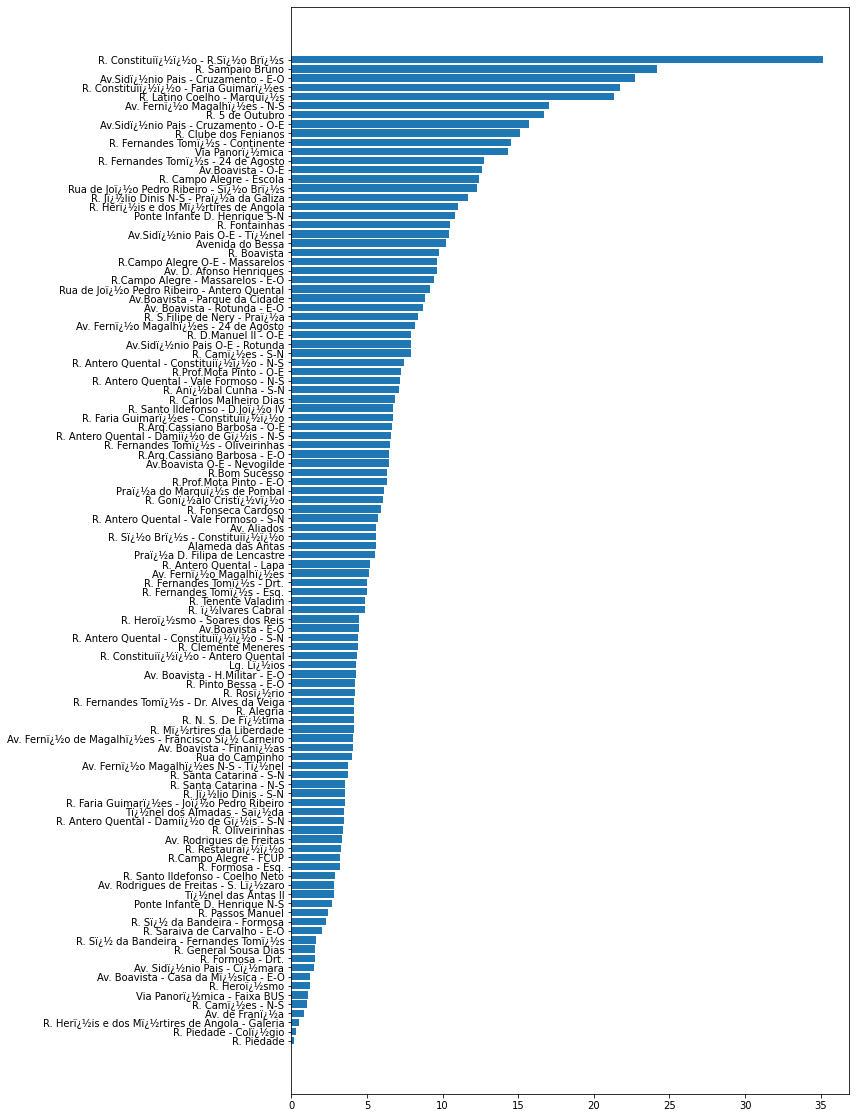

In [151]:
plt.figure(figsize=(10,20))
averages= traffic_2018_2019.groupby(['name']).AveragedtrafficPerPeriod.mean()
averages = averages.sort_values(ascending= True)
plt.barh(averages.index, averages)

### What day of the week is the busiest one in average in 18/19?

<BarContainer object of 7 artists>

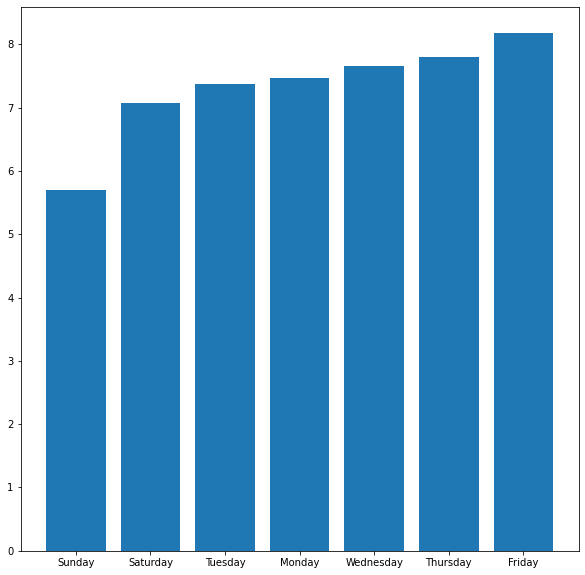

In [152]:
plt.figure(figsize=(10,10))
traffic_week= traffic_2018_2019.groupby(['week_day']).AveragedtrafficPerPeriod.mean()
traffic_week = traffic_week.sort_values(ascending= True)
plt.bar(traffic_week.index, traffic_week)

### What day of the week is the noisiest in average in 18/19?

<BarContainer object of 7 artists>

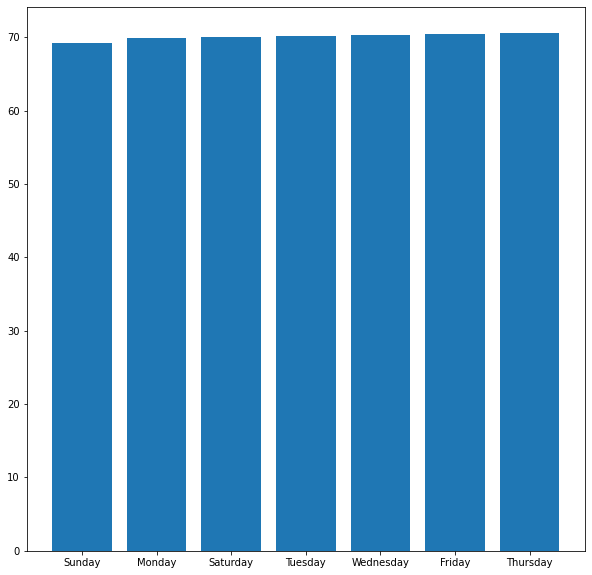

In [153]:
noise_week= traffic_2018_2019.groupby(['week_day']).avg_laeq_before.mean()
noise_week = noise_week.sort_values(ascending= True)
plt.bar(noise_week.index, noise_week)

### What day of the week has poorer air quality in average in 18/19?

<BarContainer object of 7 artists>

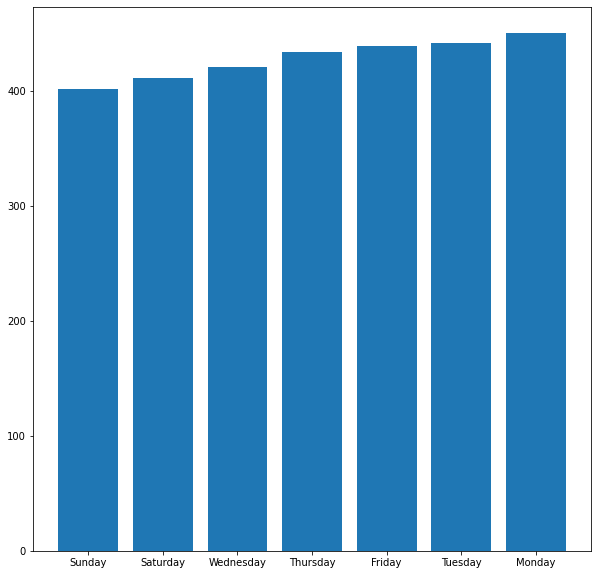

In [155]:
#pollution
plt.figure(figsize=(10,10))
polution_week= traffic_2018_2019.groupby(['week_day']).avg_co_before.mean()
polution_week = polution_week.sort_values(ascending= True)
plt.bar(polution_week.index, polution_week)

### What period of the day has the poorer air quality in average in 18/19?

<BarContainer object of 8 artists>

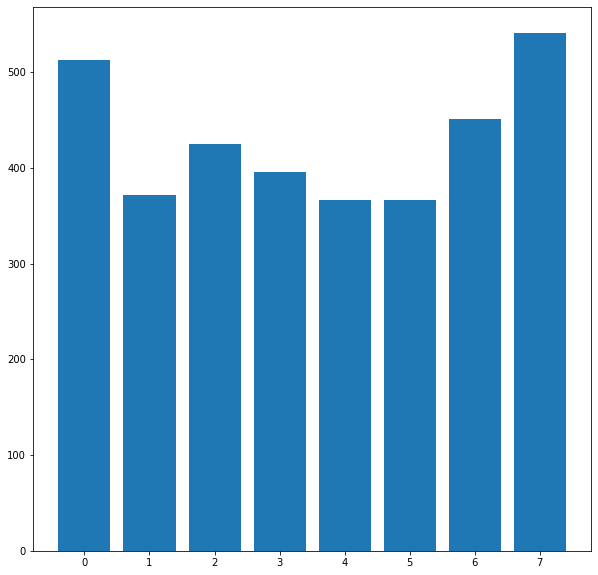

In [156]:
#pollution
polution_period= traffic_2018_2019.groupby(['code_period']).avg_co_before.mean()
polution_period = polution_period.sort_values(ascending= True)
plt.bar(polution_period.index, polution_period)

### What period of the day has more traffic in Porto city in average in 18/19?

<BarContainer object of 8 artists>

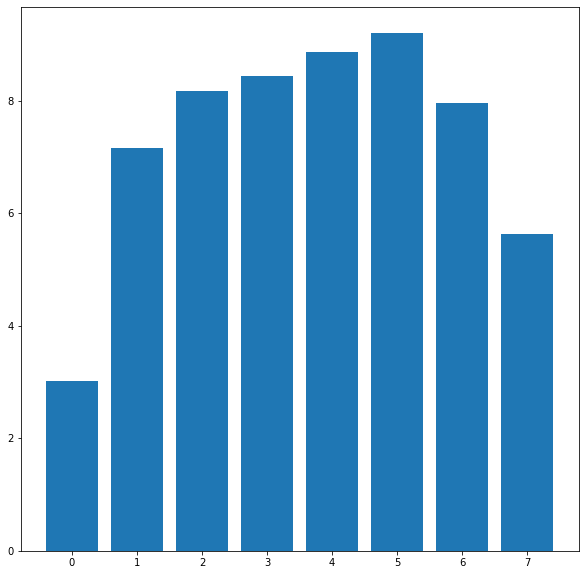

In [157]:
#traffic period
traffic_period= traffic_2018_2019.groupby(['code_period']).AveragedtrafficPerPeriod.mean()
traffic_period = traffic_period.sort_values(ascending= True)
plt.bar(traffic_period.index, traffic_period) # most intensive period is rush evening time

### What period of the day is the noisiest in average in 18/19?

<BarContainer object of 8 artists>

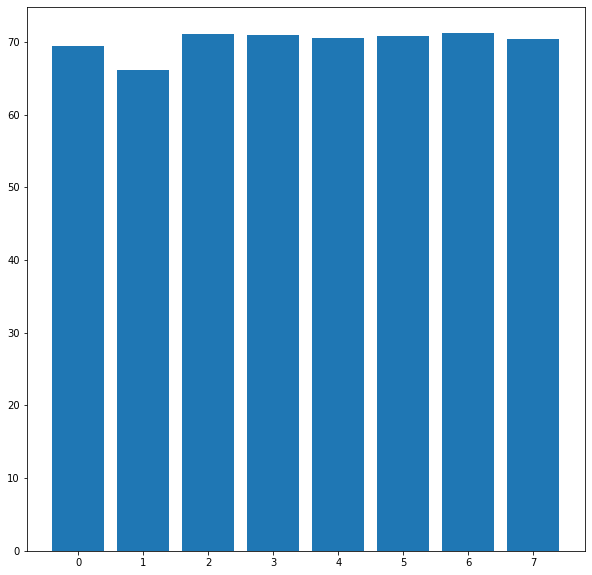

In [158]:
#noise period
noise_period= traffic_2018_2019.groupby(['code_period']).avg_laeq_before.mean()
noise_period = noise_period.sort_values(ascending= True)
plt.bar(noise_period.index, noise_period) # most intensive period is rush evening time

### In which month rains the most in average in 18/19?

<BarContainer object of 12 artists>

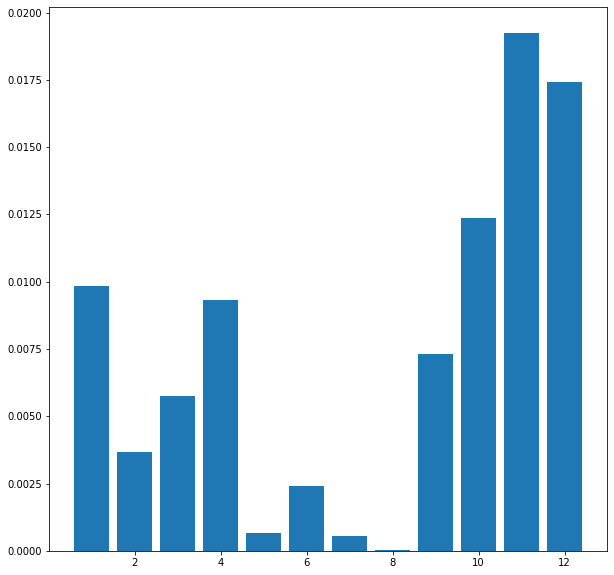

In [159]:
#precipitation month
precipitation_month= traffic_2018_2019.groupby(['Month']).avg_precipitation_before.mean()
precipitation_month = precipitation_month.sort_values(ascending= True)
plt.bar(precipitation_month.index, precipitation_month) # November

### Which month has the highest traffic values in average in 18/19?

<BarContainer object of 12 artists>

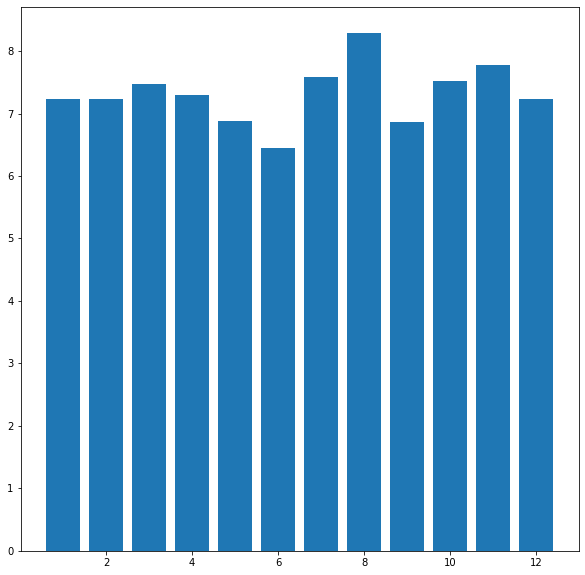

In [160]:
#traffic month
traffic_month= traffic_2018_2019.groupby(['Month']).AveragedtrafficPerPeriod.mean()
traffic_month = traffic_month.sort_values(ascending= True)
plt.bar(traffic_month.index, traffic_month) # in August there is a lot of traffic...

### In which period of the day rains the most in 18/19?

<BarContainer object of 8 artists>

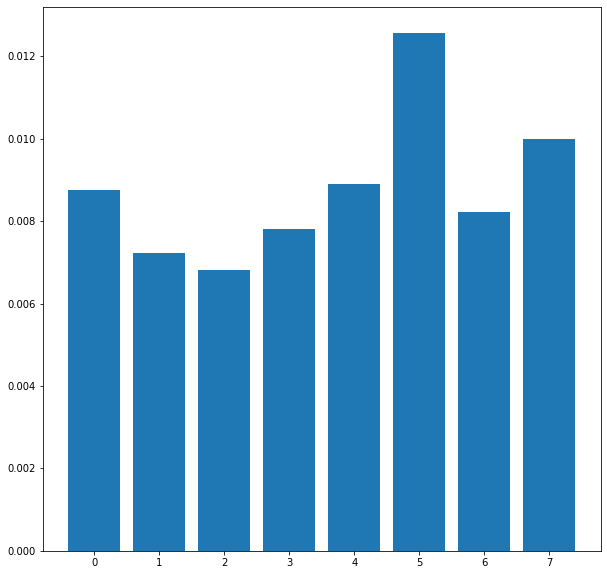

In [161]:
#precipitation period
precipitation_period= traffic_2018_2019.groupby(['code_period']).avg_precipitation_before.mean()
precipitation_period = precipitation_period.sort_values(ascending= True)
plt.bar(precipitation_period.index, precipitation_period) # it rains a lot at evening

# 2- Model fitting

In [56]:
# split train and test
traffic, traffic_test = train_test_split(traffic_2018_2019, test_size=0.30, random_state=42) #split test with 30%

In [165]:
X_train= traffic.drop(['AveragedtrafficPerPeriod'], axis=1)
y_train= traffic.AveragedtrafficPerPeriod
X_test=traffic_test.drop(['AveragedtrafficPerPeriod'], axis=1)
y_test=traffic_test.AveragedtrafficPerPeriod

### LightGBM

In [166]:
#transform object variables into category type for LGBM
for c in X_train.columns:
    col_type = X_train[c].dtype
    if col_type == 'object':
        X_train[c] = X_train[c].astype('category')
        
for c in X_test.columns:
    col_type = X_test[c].dtype
    if col_type == 'object':
        X_test[c] = X_test[c].astype('category')        

In [193]:
# create set for validation
X_trn, X_val, y_trn, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=43) #split with 30%
train_data = lgb.Dataset(data=X_trn,label=y_trn)
val_data = lgb.Dataset(data=X_val,label=y_val)

In [8]:
# previous direct fitting with a random search of the parameters pointed to some initial intervals for parameters
# and was used hyperopt to further finetuning, initially broader limits were considered and than in every iteration narrowed

def mse_model(params):
    model_lgb = lgb.train({**params},train_data, num_boost_round=10000,
                          valid_sets=[val_data], early_stopping_rounds=300, verbose_eval=None)
    
    model_result= model_lgb.predict(X_val)
    return mean_absolute_error(y_val, model_result)

param_space = {
    'objective': 'regression',
    'num_leaves': hp.choice("num_leaves", [30]),
    #'learning_rate': hp.loguniform('learning_rate', np.log(0.009), np.log(0.011)),
    'learning_rate': hp.choice('learning_rate', [0.01]),
    'force_col_wise' : True,
    'reg_alpha': 1, #hp.choice('reg_alpha', [0.9, 1, 1.1]),
    'reg_lambda': hp.choice('reg_lambda', [0.])  
}


def f(params):
    global best
    mse = mse_model(params)
    print ('loss:', mse, params)
    return {'loss': mse, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=10, trials=trials)
print ('best:')
print (best)


In [170]:
#cross validation to confirm variance is not big
dftrainLGB = lgb.Dataset(data = X_train, label = y_train, feature_name = list(X_train))

In [260]:
params = {'learning_rate': 0.009, #0.009, 0.009, 0.01
         'reg_alpha': 1,
          'reg_lambda' : 0.1,     #0.1, 0.05, 0
         'num_leaves': 32,        #32, 30, 30 mae_cv=1.457 , 1.478, 1.463 (mae_hyperopt=1.492, 1.495, 1.504)
         'force_col_wise' : True}
    
cv_results = lgb.cv(
        params,
        dftrainLGB,
        num_boost_round=10000,
        nfold=3,
        metrics=['mae', 'mape', 'rmse'],
        early_stopping_rounds=300,
        stratified = False,
        verbose_eval= 500
        )

[LightGBM] [Info] Total Bins 3739
[LightGBM] [Info] Number of data points in the train set: 103118, number of used features: 20
[LightGBM] [Info] Total Bins 3739
[LightGBM] [Info] Number of data points in the train set: 103118, number of used features: 20
[LightGBM] [Info] Total Bins 3739
[LightGBM] [Info] Number of data points in the train set: 103118, number of used features: 20
[LightGBM] [Info] Start training from score 7.340603
[LightGBM] [Info] Start training from score 7.358280
[LightGBM] [Info] Start training from score 7.310031
[500]	cv_agg's l1: 1.7159 + 0.00580503	cv_agg's mape: 0.314661 + 0.00958786	cv_agg's rmse: 6.58238 + 0.31411
[1000]	cv_agg's l1: 1.58133 + 0.00541412	cv_agg's mape: 0.263395 + 0.00961285	cv_agg's rmse: 6.45821 + 0.338732
[1500]	cv_agg's l1: 1.54156 + 0.00772846	cv_agg's mape: 0.253422 + 0.00961418	cv_agg's rmse: 6.41775 + 0.352228
[2000]	cv_agg's l1: 1.5153 + 0.00718615	cv_agg's mape: 0.247064 + 0.00971374	cv_agg's rmse: 6.3933 + 0.361971
[2500]	cv_agg'

In [ ]:
# cv shows mae is quite uniform across the validation datasets

#using parameters that both cv and hyperopt returned the lower validation mae

In [252]:
ModelLGBM= lgb.LGBMRegressor(boosting_type='gbdt', n_jobs=-1, 
                               metric= 'mse', subsample = 1, force_col_wise = True,
                              learning_rate= 0.009, colsample_bytree= 1, reg_alpha= 1, reg_lambda= 0.1,
                              n_estimators=10000, max_depth=-1, num_leaves=32 )

In [253]:
#fit the lghgbm model
ModelLGBM.fit(X_train, y_train, early_stopping_rounds= 300, eval_metric= ['mae', 'mape', 'rmse'], 
                            eval_set= [(X_test,y_test)], eval_names= ['test'], verbose= 500, feature_name= 'auto', categorical_feature= 'auto')

C:\Users\lucia\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\lucia\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 300 rounds
[500]	test's l1: 1.67116	test's mape: 0.308396	test's rmse: 5.94497	test's l2: 35.3427
[1000]	test's l1: 1.53353	test's mape: 0.255811	test's rmse: 5.82352	test's l2: 33.9134
[1500]	test's l1: 1.4929	test's mape: 0.244736	test's rmse: 5.76647	test's l2: 33.2521
[2000]	test's l1: 1.45712	test's mape: 0.235876	test's rmse: 5.74184	test's l2: 32.9687
[2500]	test's l1: 1.43561	test's mape: 0.231534	test's rmse: 5.72701	test's l2: 32.7986
[3000]	test's l1: 1.41829	test's mape: 0.227829	test's rmse: 5.72506	test's l2: 32.7763
[3500]	test's l1: 1.40509	test's mape: 0.225344	test's rmse: 5.71896	test's l2: 32.7065
Early stopping, best iteration is:
[3392]	test's l1: 1.40737	test's mape: 0.225767	test's rmse: 5.71835	test's l2: 32.6996


LGBMRegressor(colsample_bytree=1, force_col_wise=True, learning_rate=0.009,
              metric='mse', n_estimators=10000, num_leaves=32, reg_alpha=1,
              reg_lambda=0.1, subsample=1)

In [213]:
# lower than 23 % error (mape) in average 

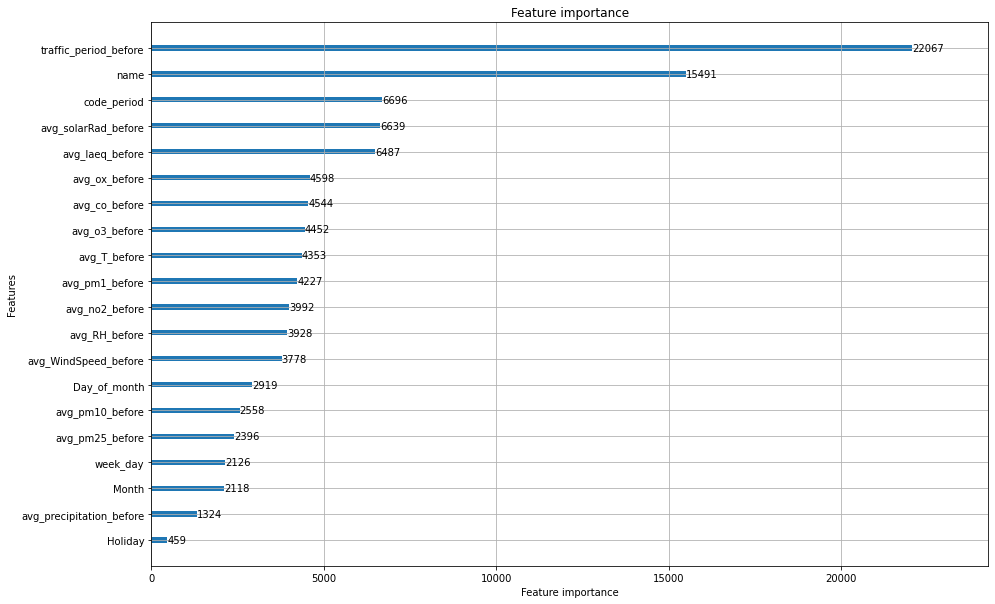

In [261]:
lgb.plot_importance(ModelLGBM, figsize = (15,10))
plt.show()

### Random Forest Regressor

In [82]:
#remove NaN RF does not handle it...
#get dummies for names
traffic_2018_2019_=traffic_2018_2019.dropna()
dummies_= pd.get_dummies(traffic_2018_2019_['name']) #get dummies for categoricals
traffic_2018_2019_ = pd.concat([traffic_2018_2019_, dummies_], axis=1)
traffic_2018_2019_=traffic_2018_2019_.drop('name', axis=1) # we dont need it anymore

In [83]:
traffic_, traffic_test_ = train_test_split(traffic_2018_2019_, test_size=0.30, random_state=42) #split test with 30%
X_train_= traffic_.drop(['AveragedtrafficPerPeriod'], axis=1)
y_train_= traffic_.AveragedtrafficPerPeriod
X_test_=traffic_test_.drop(['AveragedtrafficPerPeriod'], axis=1)
y_test_=traffic_test_.AveragedtrafficPerPeriod

In [85]:
#convert week name to numbers
b=[]
for day in X_train_['week_day']:
    if day=='Sunday':
        b.append(1)
    elif day=='Monday':
        b.append(2)
    elif day=='Tuesday':
        b.append(3)
    elif day=='Wednesday':
        b.append(4) 
    elif day=='Thursday':
        b.append(5)        
    elif day=='Friday':
        b.append(6)        
    else:
        b.append(7) 
        
X_train_['week_day']=b        

In [86]:
b=[] #same for test
for day in X_test_['week_day']:
    if day=='Sunday':
        b.append(1)
    elif day=='Monday':
        b.append(2)
    elif day=='Tuesday':
        b.append(3)
    elif day=='Wednesday':
        b.append(4) 
    elif day=='Thursday':
        b.append(5)        
    elif day=='Friday':
        b.append(6)        
    else:
        b.append(7) 
        
X_test_['week_day']=b  

In [89]:
# create set for validation
X_trn_, X_val_, y_trn_, y_val_ = train_test_split(X_train_, y_train_, test_size=0.3, random_state=43) #split with 30%

In [90]:
modelRF=RandomForestRegressor(random_state=0, verbose=1, n_jobs=-1, criterion='mse', max_depth=None, n_estimators=100, min_samples_leaf=2, min_samples_split= 4)
modelRF.fit(X_trn_, y_trn_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


RandomForestRegressor(min_samples_leaf=2, min_samples_split=4, n_jobs=-1,
                      random_state=0, verbose=1)

In [91]:
pred_trn=modelRF.predict(X_trn_)
mean_absolute_error(y_trn_, pred_trn)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


0.6365616256824186

In [92]:
pred_val=modelRF.predict(X_val_)
mean_absolute_error(y_val_, pred_val) # 1.38 apparently not bad (lightgbm got 1.492 in the validation set)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


1.3847638744544895

In [95]:
#check for heavy overfitting
cv_results_RF = cross_validate(modelRF, X_train_, y_train_, cv=3, scoring=('neg_mean_absolute_error'), return_train_score=True, n_jobs= -1)

In [96]:
print(cv_results_RF['test_score'], cv_results_RF['train_score']) # apparently not overfitting

[-1.34465355 -1.35006838 -1.36443337] [-0.65102774 -0.64858727 -0.65272004]


In [97]:
#evaluate test set
modelRF.fit(X_train_, y_train_)
pred_test=modelRF.predict(X_test_)
mean_absolute_error(y_test_, pred_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished


1.3528635913281102

In [ ]:
# seems better than Lightgbm

In [99]:
y_test_.mean()

7.370103111591249

In [100]:
mape_proxy= mean_absolute_error(y_test_, pred_test)/y_test_.mean()
mape_proxy

0.1835610127625499

In [122]:
#optimize hyperparameters

def mse_model(params):
   
    modelRF=RandomForestRegressor(**params, random_state=0, verbose=0, n_jobs=-1, 
                                  criterion='mse', max_depth=None)
    
    modelRF.fit(X_trn_, y_trn_)
    pred_val=modelRF.predict(X_val_)

    return mean_absolute_error(y_val_, pred_val)

param_space = {
    'min_samples_leaf': hp.choice("min_samples_leaf", [1,2,4]),
    'min_samples_split': hp.choice("min_samples_split", [2,4,8]),
    'n_estimators': hp.choice('n_estimators', [100,200,400])
}


def f(params):
    global best
    mse = mse_model(params)
    print ('loss:', mse, params)
    return {'loss': mse, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=10, trials=trials)
print ('best:')
print (best)

loss:                                                                                                                                                      
1.3800114824614602                                                                                                                                         
{'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}                                                                                       
loss:                                                                                                                                                      
1.3692291481657621                                                                                                                                         
{'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 400}                                                                                       
loss:                                                           

In [ ]:
#apparently best parameters: 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 400

In [123]:
modelRF_=RandomForestRegressor(random_state=0, verbose=1, n_jobs=-1, criterion='mse', max_depth=None, n_estimators=400, min_samples_leaf=1, min_samples_split= 8)
cv_results_OP = cross_validate(modelRF_, X_train_, y_train_, cv=3, scoring=('neg_mean_absolute_error'), return_train_score=True, n_jobs= -1)

In [126]:
print(cv_results_OP['test_score'], cv_results_OP['train_score']) # not very overfitting

[-1.32613514 -1.32997998 -1.34710581] [-0.68510335 -0.68163696 -0.68386028]


In [125]:
#evaluate test set
modelRF_.fit(X_train_, y_train_)
pred_test=modelRF_.predict(X_test_)
mean_absolute_error(y_test_, pred_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 10.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    3.4s finished


1.3284450701666015

In [127]:
mape_proxy_op=mean_absolute_error(y_test_, pred_test)/y_test_.mean()*100 
mape_proxy_op

18.024782693708914

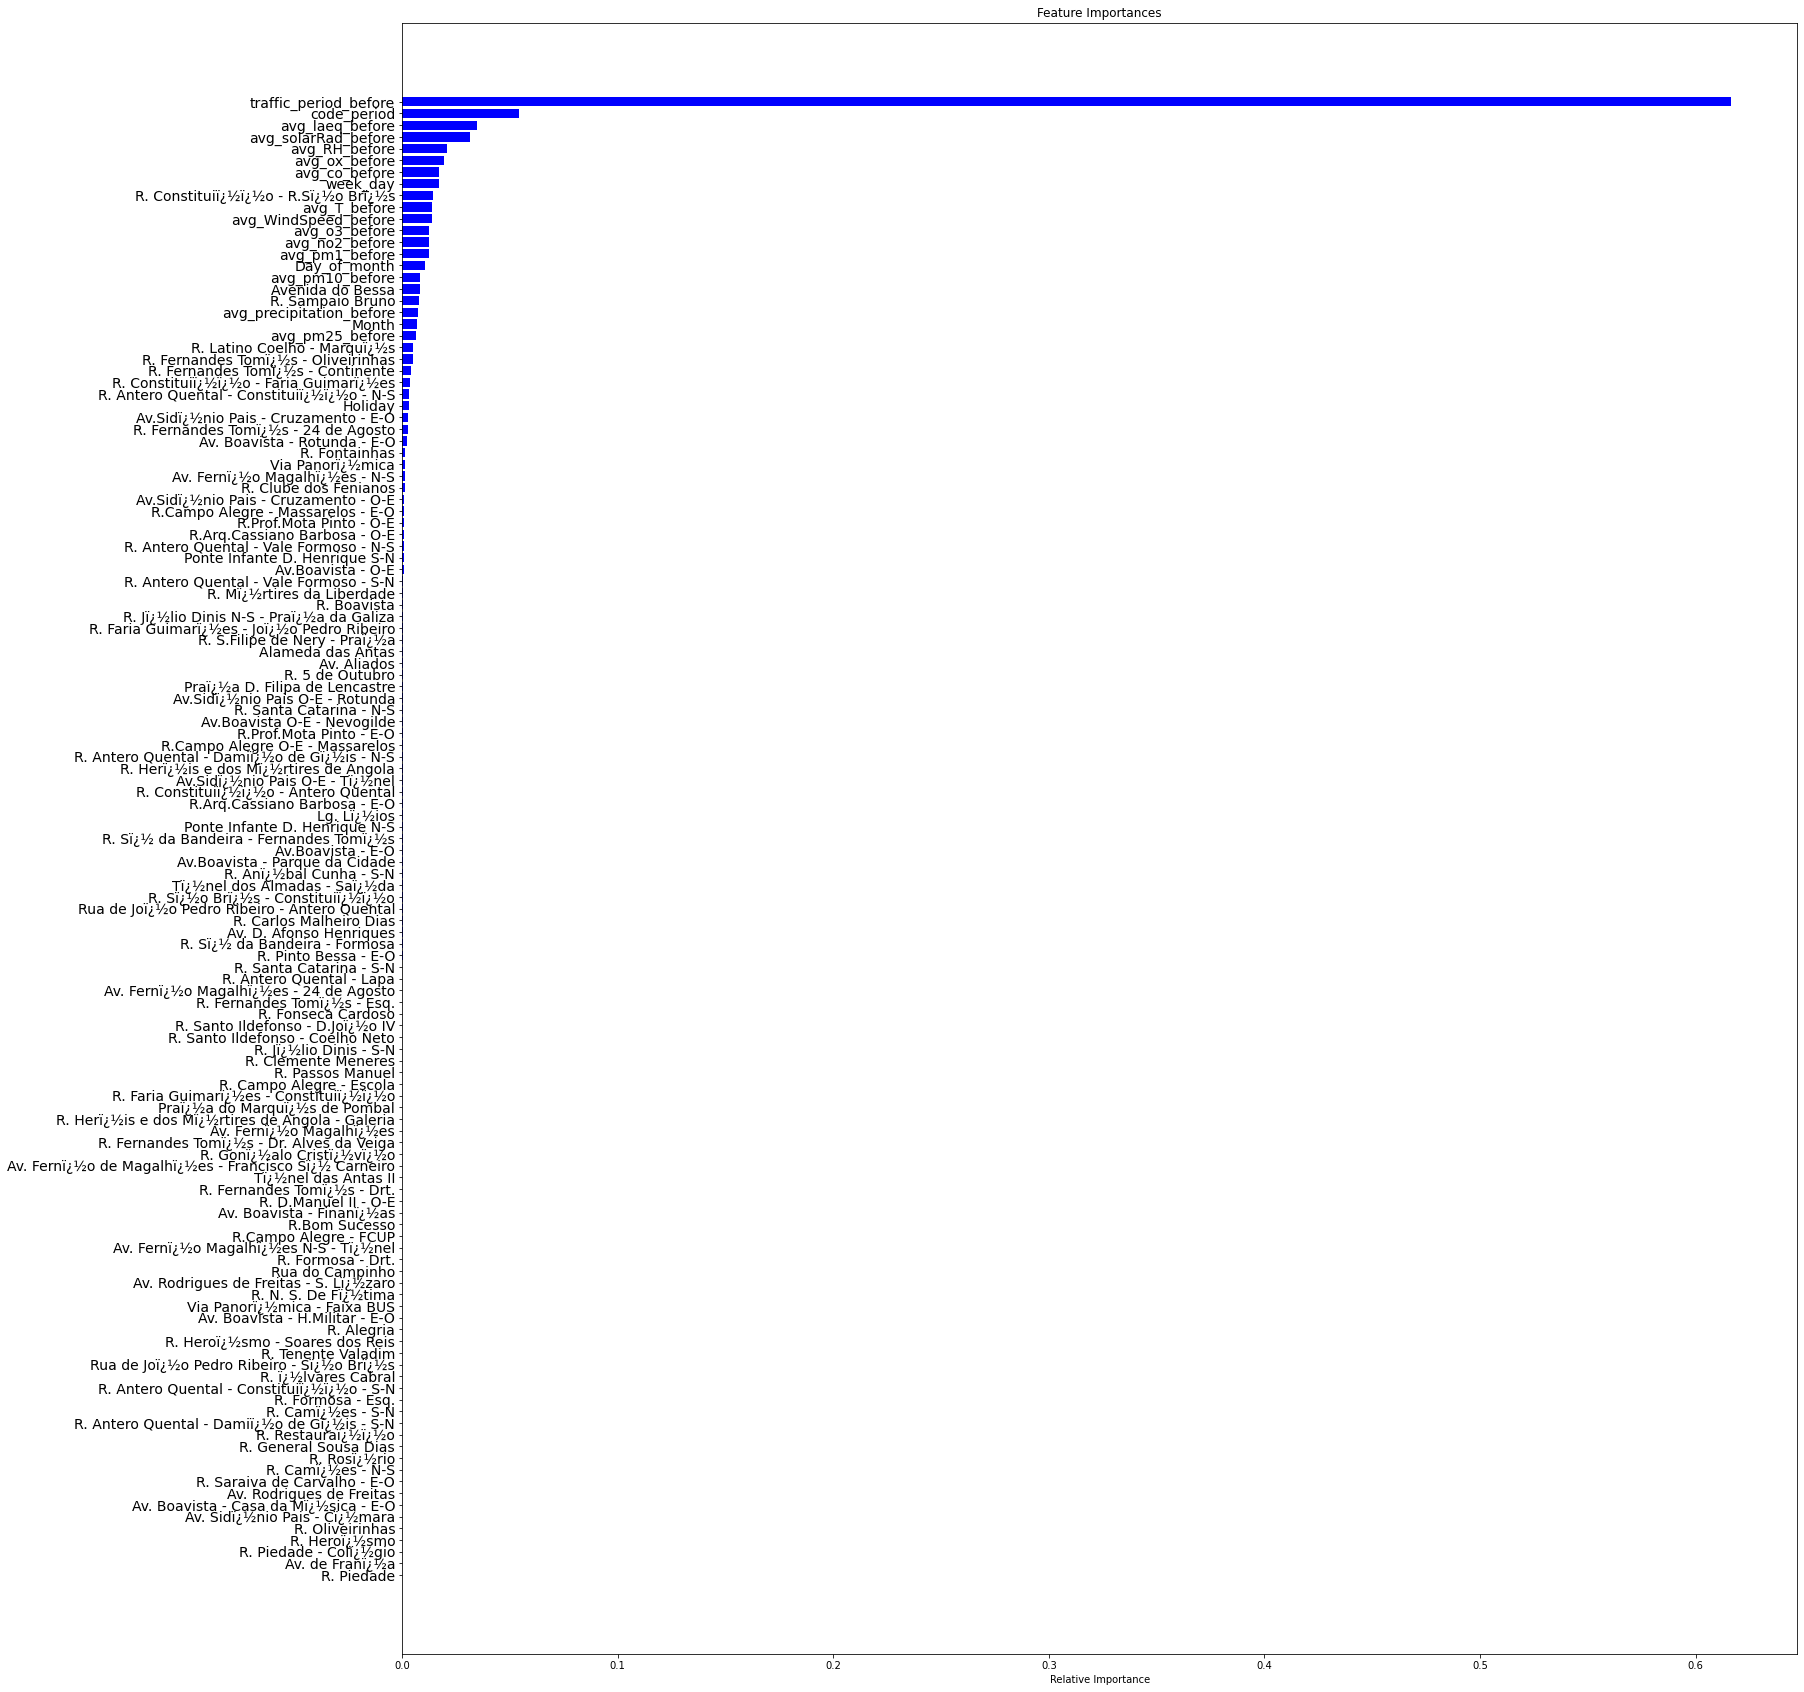

In [137]:
plt.figure(figsize=(25,30))
importances = modelRF_.feature_importances_
indices = np.argsort(importances)
features = [X_train_.columns[i] for i in indices]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features, fontsize=14)
plt.xlabel('Relative Importance')
plt.show()

# Conclusions

#### This modelling analysis is easily scalable to any city.

#### The social impact of this analysis is to try to understand what might be the most intensively used road segments by cars in a certain period of the day for any specific time in a year and location. This model may help on distributing traffic resources (traffic police force, adjust semafore times) for allowing a better and smootlhy traffic development. A better and optimized traffic flow management allows helping decrease CO2 levels, noise and other quality air variables in the city.

# Future work

#### Definitely consider the additional data from 2020 and 2021, and also try to infer the impact of COVID restrictions on the busiest road segments as well as on air quality and noise levels in the city.